In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("Data/tmdb_results_combined.csv.gz")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                4046 non-null   object 
 1   adult                  4043 non-null   float64
 2   backdrop_path          2329 non-null   object 
 3   belongs_to_collection  325 non-null    object 
 4   budget                 4043 non-null   float64
 5   genres                 4043 non-null   object 
 6   homepage               322 non-null    object 
 7   id                     4043 non-null   float64
 8   original_language      4043 non-null   object 
 9   original_title         4043 non-null   object 
 10  overview               3961 non-null   object 
 11  popularity             4043 non-null   float64
 12  poster_path            3687 non-null   object 
 13  production_companies   4043 non-null   object 
 14  production_countries   4043 non-null   object 
 15  rele

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/tJLV3BAlHOgscVOrA99Wnb2gAef.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.30,1263.0,PG-13
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,4.75,4.0,NaN
3,tt0116916,0.0,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549.0,en,The Dark Mist,...,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.0,3.50,2.0,PG
4,tt0118589,0.0,/qSukSg6JBR3A4iEkRGIfHPC0W5H.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,...,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.40,133.0,PG-13


**How many movies had at least some valid financial information (values > 0 for budget OR revenue)?**


In [55]:
filter_budget = df['budget']==0
filter_revenue = df['revenue']==0
df['is_financial_info'] = ~(filter_budget & filter_revenue)
df['is_financial_info']

0        True
1        True
2       False
3       False
4        True
        ...  
4041    False
4042    False
4043    False
4044    False
4045    False
Name: is_financial_info, Length: 4046, dtype: bool

In [56]:
df.columns

Index(['imdb_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'certification', 'is_financial_info'],
      dtype='object')

Movies with financial infos: 1124
Movies missing budget or revenue infos financial infos: 2922
------------------------------


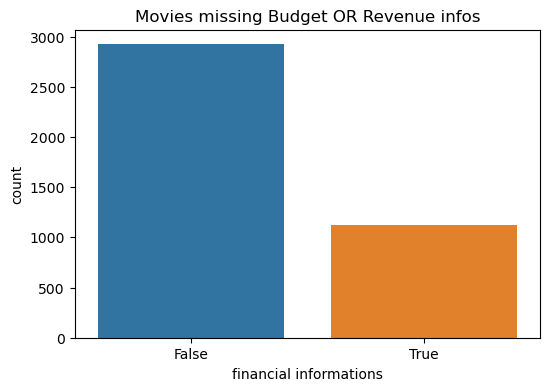

In [57]:
fig, axes = plt.subplots(figsize=(6,4))
sns.countplot(data=df,x='is_financial_info',ax=axes)
axes.set_title("Movies missing Budget OR Revenue infos")
axes.set_xlabel("financial informations")
print(f"Movies with financial infos: {df['is_financial_info'].sum()}")
print(f"Movies missing budget or revenue infos financial infos: {df.shape[0]-df['is_financial_info'].sum()}")
print('-'*30)

In [120]:
df_with_fin = df[df['is_financial_info']==True]

certification
R        350
PG-13    211
PG        57
NR        34
G         21
Name: count, dtype: int64
------------------------------


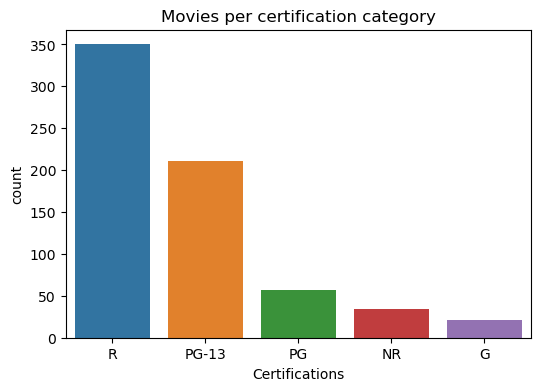

In [121]:

fig, axes = plt.subplots(figsize=(6,4))
sns.countplot(data=df_with_fin,x='certification',ax=axes,order=df_with_fin['certification'].value_counts().index)
axes.set_title("Movies per certification category")
axes.set_xlabel("Certifications")
print(df_with_fin['certification'].value_counts())
print('-'*30)

In [122]:
revenue_per_certif = df.groupby(df_with_fin['certification'])['revenue'].mean().map('${:,.2f}'.format)
revenue_per_certif

certification
G        $121,029,548.95
NR         $2,370,661.82
PG       $148,657,789.39
PG-13     $97,720,582.02
R         $29,997,313.28
Name: revenue, dtype: object

------------------------------


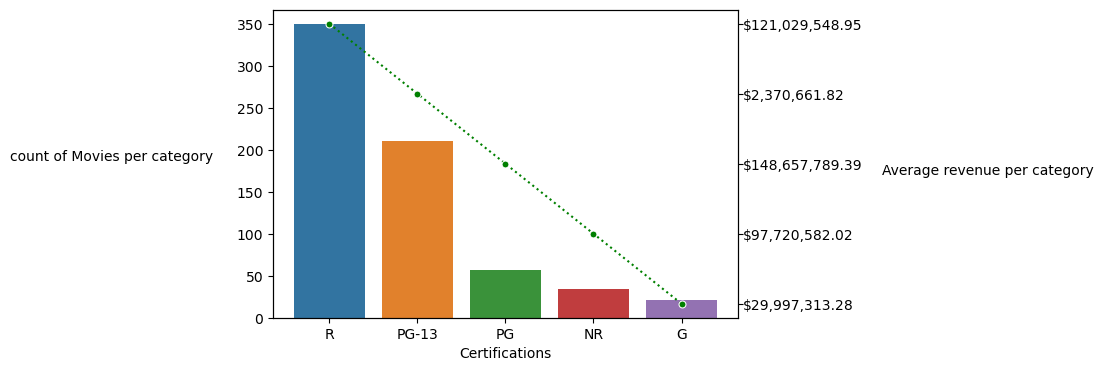

In [137]:

fig, axes = plt.subplots(figsize=(6,4))
sns.countplot(data=df_with_fin,x='certification',ax=axes,order=df_with_fin['certification'].value_counts().index)
axes.set_xlabel("Certifications")
axes.set_ylabel("count of Movies per category",rotation=360,labelpad=90)
axes2 = plt.twinx()
sns.lineplot(data=revenue_per_certif,color='green',ls='dotted',marker='.',markersize=10, ax=axes2)
axes2.set_ylabel("Average revenue per category",rotation=360,labelpad=90)
axes2.tick_params(pad=0)
print('-'*30)

In [131]:
budget_per_certif = df.groupby(df_with_fin['certification'])['budget'].mean().map('${:,.2f}'.format)
budget_per_certif

certification
G        $35,142,857.14
NR        $1,085,941.24
PG       $44,088,060.70
PG-13    $39,634,818.78
R        $18,278,328.50
Name: budget, dtype: object

------------------------------


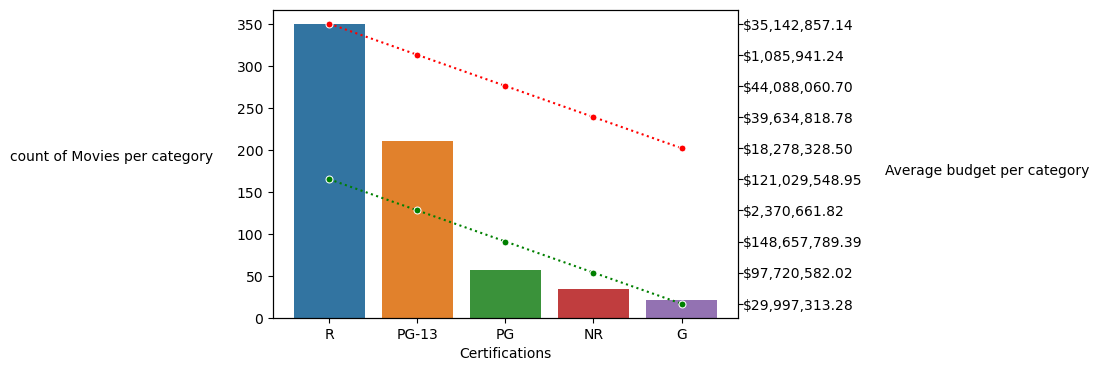

In [138]:
fig, axes = plt.subplots(figsize=(6,4))
sns.countplot(data=df_with_fin,x='certification',ax=axes,order=df_with_fin['certification'].value_counts().index)
axes.set_xlabel("Certifications")
axes.set_ylabel("count of Movies per category",rotation=360,labelpad=90)
axes2 = plt.twinx()
sns.lineplot(data=budget_per_certif,c='r',ls='dotted',marker='.',markersize=10, ax=axes2)
axes2.set_ylabel("Average budget per category",rotation=360,labelpad=90)
axes2.tick_params(pad=0)
sns.lineplot(data=revenue_per_certif,color='green',ls='dotted',marker='.',markersize=10, ax=axes2)
print('-'*30)